# Creating Couzin Data&Video Pipeline

In [1]:
%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown as md

from fish_models.gym_interface import TrackGeneratorGym
from fish_models.models.pascals_lstms.couzin import ConstantSpeedCouzinModel

## Parameters (you can edit this)

In [6]:
# For the track
n_guppies = 8
frequency_hz = 25
n_timesteps = 2000

# Initial Poses
rng = np.random.default_rng()
initial_positions = rng.uniform(low=-30, high=30, size=(n_guppies, 2))
initial_orientations = rng.uniform(low=-np.pi, high=np.pi, size=(n_guppies, 1))
initial_poses = np.concatenate([initial_positions, initial_orientations], axis=1)

# The model
model = ConstantSpeedCouzinModel(
    speed_cm_s=8.0,
    zor=1.0,
    zoo=4.0,
    zoa=40.0,
    zowr=20.0,
    world_bounds=[[-50, -50], [50, 50]],
    max_turn_speed_rad_s=np.pi / 4,
    fov=5 / 6 * 2 * np.pi,
    neighbours=None,
    noise=0.0,
    time_step_s=1 / frequency_hz,
)

# Paths
data_dir = Path("../../data/raw/")
video_dir = Path("../../data/visualizations/")
overwrite = True  # overwrite if video exists. Can save time
track_name = "test.hdf5"

## Create Track

In [7]:
generator = TrackGeneratorGym(model=model, world_size=[100, 100], frequency=frequency_hz)

track = generator.create_track(
    n_guppies=n_guppies, trackset_len=n_timesteps, initial_poses=initial_poses
)

100%|██████████| 1999/1999 [00:07<00:00, 262.39it/s]


(8, 2000, 3)


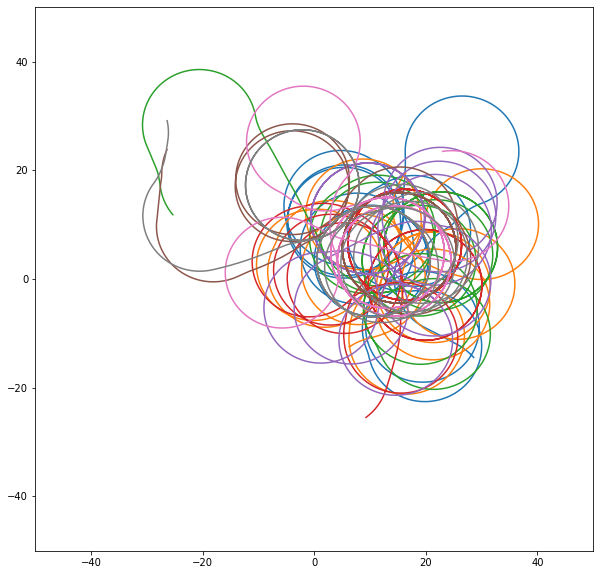

In [8]:
print(track.shape)
fig = plt.figure(figsize=(10, 10))
plt.xlim(-50, 50)
plt.ylim(-50, 50)
for fish_id in range(track.shape[0]):
    plt.plot(
        track[fish_id, :, 0],
        track[fish_id, :, 1],
    )
plt.show()

## Save Track

In [9]:
f = generator.as_io_file(track)
f.save_as(data_dir / track_name) # automatically overwrites

<HDF5 file "38726981-8ee3-4750-9a49-2f279209975d" (mode r+)>

## Create Video (via robofish-trackviewer-render)

In [13]:
data_paths_string = "".join([f"{p} " for p in data_dir.glob("*.hdf5")])[:-1]
video_paths = [ (video_dir / p.stem).with_suffix(".mp4") for p in data_dir.glob("*.hdf5") ]
video_paths_string = "".join([f"{p} " for p in video_paths])[:-1]
overwrite_flag = "True" if overwrite else "False"

In [14]:
data_paths_string

'../../data/raw/test.hdf5'

In [15]:
%%bash -s "$data_paths_string" "$video_paths_string" "$overwrite_flag"
# activate venv
source ../../venv_fish_models/bin/activate
# Convert to bash arrays
d=($1)
v=($2)
# Loop though both arrays at once
for ((i=0;i<${#d[@]};i++))
do
    if [ ! -e ${v[$i]} -o "True" = $3  ]
    then
    robofish-trackviewer-render ${d[$i]} -o ${v[$i]}
    echo "created video: " ${v[$i]}
    fi
done

created video:  ../../data/visualizations/test.mp4


frame= 2000 fps=530 q=-1.0 Lsize=    1597kB time=00:01:19.88 bitrate= 163.8kbits/s speed=21.2x    


## Display Video

In [16]:
print(f"{len(video_paths)} videos exist in {video_dir}")
md(f"<video controls src={video_paths[0]}/>")

1 videos exist in ../../data/visualizations


<video controls src=../../data/visualizations/test.mp4/>